### Pre-Requesities
1. Add a sigmoid after class conv and create class prob output.
2. Verify the associated node names match the ones in this notebook.
3. Load the modified graph into this notebook to make other changes.

In [345]:
import onnx
import onnxruntime as ort
import numpy as np
import os
from sima_utils.onnx import onnx_helpers as oh
from onnx import shape_inference
from copy import deepcopy
import cv2
import matplotlib.pyplot as plt
import torch
import time
import torchvision
import torch.nn.functional as F
import shutil

In [412]:
yolov9s_dseg = "/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/seg_v001/bag_seg_v9s_post_coco_png2/weights/best.onnx"
yolov9s_dseg_extracted = "/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/seg_v001/bag_seg_v9s_post_coco_png2/weights/best_extracted.onnx"
yolov9s_dseg_post_surg = "/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/seg_v001/bag_seg_v9s_post_coco_png2/weights/yolov9s_dseg_post_surgery.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/v005/bag_port_det_v005_anneal3/weights/best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/v004/bag_port_det_v0042/weights/best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/v003/bag_port_det_v0033/weights/best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/bag_port_det/bag_port_det15/weights/best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/pm_yolo9s_gst3/weights/best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/bag_port_det/bag_port_det10/weights/best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/bag_port_det/bag_port_det6/weights/best.onnx"
#"yolov9s_mono.onnx"#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/onnx-modifier/modified_onnx/pm_yolov9s/pm_yolov9s.onnx"

In [413]:
m = onnx.load(yolov9s_dseg)

In [414]:
mask_coefs = ["/model.35/cv7.0/cv7.0.2/Conv_output_0",
              "/model.35/cv7.1/cv7.1.2/Conv_output_0",
              "/model.35/cv7.2/cv7.2.2/Conv_output_0"]
cls_logits = ["/model.35/cv5.0/cv5.0.2/Conv_output_0",
              "/model.35/cv5.1/cv5.1.2/Conv_output_0",
              "/model.35/cv5.2/cv5.2.2/Conv_output_0"]
bbox_potentials = ["/model.35/cv4.0/cv4.0.1/act/Mul_output_0",
                   "/model.35/cv4.1/cv4.1.1/act/Mul_output_0",
                   "/model.35/cv4.2/cv4.2.1/act/Mul_output_0"]
mask = ["output1"]
inp = ["images"]

In [415]:
onnx.utils.extract_model(yolov9s_dseg, yolov9s_dseg_extracted, inp, bbox_potentials+cls_logits+mask_coefs+mask)

In [416]:
m_extracted = onnx.load(yolov9s_dseg_extracted)

## add sigmoids after class logits to extracted graph

In [417]:
# remove cls logit from op -> need to add sigmoid output 
#oh.remove_outputs_by_name_list(m_extracted, cls_logits)

In [418]:
def change_op_name(m, old_op_name, new_op_name):
    for op in m.graph.output:
        if op.name == old_op_name:
            op.name = new_op_name

In [419]:
for i, cls_logit in enumerate(cls_logits):
    cls_logit_node = cls_logit.strip("_output_0")
    n = onnx.helper.make_node("Sigmoid", inputs=[cls_logit],
                               outputs=[f"cls_prob_{i}"])
    oh.insert_node(m_extracted, cls_logit_node, n, insert_only=True)

In [420]:
cls_probs_op = [f"cls_prob_{i}" for i in range(3)]

In [421]:
for old_cls_op, new_op in zip(cls_logits, cls_probs_op):
    change_op_name(m_extracted, old_cls_op, new_op)

In [422]:
#change_op_name(m_extracted, "output1", "mask")

In [423]:
onnx.save(m_extracted, "weights/yolov9_dseg_edited.onnx")

## bbox nodes

In [424]:
bbox_convs = ["/model.35/cv4.0/cv4.0.2/Conv",
              "/model.35/cv4.1/cv4.1.2/Conv",
              "/model.35/cv4.2/cv4.2.2/Conv"]

In [425]:
followup_conv = "/model.35/dfl2/conv/Conv"

In [426]:
anchor_points = "/model.35/Constant_7_output_0"
strides = "/model.35/Constant_10_output_0"

### anchor and stride analysis

In [427]:
anchor_tensor = oh.find_initializer_value(m, anchor_points)

In [428]:
anchor_tensor

array([[[ 0.5,  1.5,  2.5, ..., 17.5, 18.5, 19.5],
        [ 0.5,  0.5,  0.5, ..., 19.5, 19.5, 19.5]]], dtype=float32)

In [429]:
anchor_tensor.shape

(1, 2, 8400)

In [430]:
stride_tensor = oh.find_initializer_value(m, strides)

In [431]:
stride_tensor

array([[ 8.,  8.,  8., ..., 32., 32., 32.]], dtype=float32)

In [432]:
stride_tensor.shape

(1, 8400)

#### stride analysis

In [433]:
stride_tensor

array([[ 8.,  8.,  8., ..., 32., 32., 32.]], dtype=float32)

In [434]:
stride_tensor[0][6400-1], stride_tensor[0][6400]

(8.0, 16.0)

In [435]:
stride_tensor[0][6400+1600-1], stride_tensor[0][6400+1600]

(16.0, 32.0)

In [436]:
print(np.unique(stride_tensor[0][0:6400]))
print(np.unique(stride_tensor[0][6400:6400+1600]))
print(np.unique(stride_tensor[0][6400+1600:]))

[8.]
[16.]
[32.]


In [437]:
np.unique(stride_tensor)

array([ 8., 16., 32.], dtype=float32)

#### anchor analysis

In [438]:
anchor_tensor

array([[[ 0.5,  1.5,  2.5, ..., 17.5, 18.5, 19.5],
        [ 0.5,  0.5,  0.5, ..., 19.5, 19.5, 19.5]]], dtype=float32)

In [439]:
anchor_tensor.shape

(1, 2, 8400)

In [440]:
anchor_tensor[:,:,:6400]

array([[[ 0.5,  1.5,  2.5, ..., 77.5, 78.5, 79.5],
        [ 0.5,  0.5,  0.5, ..., 79.5, 79.5, 79.5]]], dtype=float32)

In [441]:
anchor_tensor[:,:,:80]

array([[[ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
         20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5,
         30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5,
         40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5,
         50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5,
         60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5,
         70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
          0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
          0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
          0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
          0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
          0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
          0.5,  0.5,  0.5,  0.5, 

In [442]:
anchor_tensor[:,:,80:160]

array([[[ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
         20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5,
         30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5,
         40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5,
         50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5,
         60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5,
         70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5],
        [ 1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,
          1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,
          1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,
          1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,
          1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,
          1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  1.5,
          1.5,  1.5,  1.5,  1.5, 

In [443]:
anchor_tensor[:,:,6400:6400+1600]

array([[[ 0.5,  1.5,  2.5, ..., 37.5, 38.5, 39.5],
        [ 0.5,  0.5,  0.5, ..., 39.5, 39.5, 39.5]]], dtype=float32)

In [444]:
anchor_tensor[:,:,6400+1600:]

array([[[ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
         10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
          0.5,  1.5,  2.5,  3.5,  

### create conv filter for xyxy2xhwh

In [445]:
w_template = [[[[-0.5]],[[0]],[[0.5]],[[0]]],
              [[[0]],[[-0.5]],[[0]],[[0.5]]],
              [[[1]],[[0]],[[1]],[[0]]],
              [[[0]],[[1]],[[0]],[[1]]]]
w_template = np.array(w_template).astype(np.float32)
strides = [8, 16, 32]

In [446]:
w_template.shape

(4, 4, 1, 1)

### Create Add weight tensor

In [447]:
a1 = anchor_tensor[:,:,:6400].reshape(1,2,80,80)
zs = np.zeros((1,2,80,80)).astype(np.float32)
prep_a1 = np.concatenate((a1, zs), axis=1)
prep_a1 = prep_a1*8

a2 = anchor_tensor[:,:,6400:6400+1600].reshape(1,2,40,40)
zs = np.zeros((1,2,40,40)).astype(np.float32)
prep_a2 = np.concatenate((a2, zs), axis=1)
prep_a2 = prep_a2*16

a3 = anchor_tensor[:,:,6400+1600:].reshape(1,2,20,20)
zs = np.zeros((1,2,20,20)).astype(np.float32)
prep_a3 = np.concatenate((a3, zs), axis=1)
prep_a3 = prep_a3*32

In [448]:
prep_a1.shape, prep_a2.shape, prep_a3.shape

((1, 4, 80, 80), (1, 4, 40, 40), (1, 4, 20, 20))

In [449]:
add_tensors = [prep_a1, prep_a2, prep_a3]

### start surgery

In [450]:
collect_nodes = []
collect_inits = []
collect_inps = []
collect_ops = []
inp_shapes = []
op_shapes = []
szs = [80, 40, 20]
for bbox_conv_idx, conv_name in enumerate(bbox_convs):
    node_conv = oh.find_node(m, conv_name)
    conv_extracted = oh.extract_model(m, node_conv.input[0:1], node_conv.output)
    followup_conv_node = oh.find_node(m, followup_conv)
    # build equivalent graph and infer
    # Add a split to feed convs
    # split = onnx.helper.make_node("Split",
    #                         inputs=[f"cust_{node_conv.input[0]}"],
    #                         outputs=[f"bbox_{bbox_conv_idx}_split_op_0",
    #                                  f"bbox_{bbox_conv_idx}_split_op_1",
    #                                  f"bbox_{bbox_conv_idx}_split_op_2",
    #                                  f"bbox_{bbox_conv_idx}_split_op_3"],
    #                         axis=1,
    #                         num_outputs=4)
    # collect_nodes.append(split)
    # add a slice node for each conv
    for i in range(4):
        n = onnx.helper.make_node("Slice", inputs=[f"cust_{node_conv.input[0]}", "starts", "ends", "axes"],
                              outputs=[f"bbox_{bbox_conv_idx}_slice_{i}_op"])
        s = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_slice_{i}_starts", data_type=onnx.TensorProto.INT32,
                                dims=[1],
                                vals=[16*i])
        e = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_slice_{i}_ends", data_type=onnx.TensorProto.INT32,
                                dims=[1],
                                vals=[16*(i+1)])
        a = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_slice_{i}_axes", data_type=onnx.TensorProto.INT32,
                                dims=[1],
                                vals=[1])
        n.input[1] = s.name
        n.input[2] = e.name
        n.input[3] = a.name
        collect_nodes.append(n)
        collect_inits.extend([s,e,a])
    collect_inps.append(f"cust_{node_conv.input[0]}")
    inp_shapes.append([1, 64, szs[bbox_conv_idx], szs[bbox_conv_idx]])
    # add 4 new convs
    new_convs = []
    for i in range(4):
        n = onnx.helper.make_node("Conv", inputs=[f"bbox_{bbox_conv_idx}_slice_{i}_op", "w", "b"],
                              outputs=[f"bbox_{bbox_conv_idx}_conv_{i}_op"], dilations=[1,1],
                              group=1, kernel_shape=[1,1],
                              pads=[0,0,0,0],
                              strides=[1,1])
        new_convs.append(n)
    w = oh.find_initializer_value(conv_extracted, node_conv.input[1])
    b = oh.find_initializer_value(conv_extracted, node_conv.input[2])
    # create weight initializers
    ws = []
    for i in range(4):
        start_idx = 16*i
        wi = w[i*16:(i+1)*16,:,:,:]
        assert wi.shape == (16,16,1,1)
        wi = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_conv_{i}_w", data_type=onnx.TensorProto.FLOAT,
                                dims=list(wi.shape),
                                vals=wi.flatten().tolist())
        ws.append(wi)
    # create bias initializers
    bs = []
    for i in range(4):
        start_idx = 16*i
        wi = b[i*16:(i+1)*16]
        assert wi.shape == (16,)
        wi = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_conv_{i}_b", data_type=onnx.TensorProto.FLOAT,
                                dims=list(wi.shape),
                                vals=wi.flatten().tolist())
        bs.append(wi)
    # connect weight and biases with convs
    for i, (conv, w, b) in enumerate(zip(new_convs, ws, bs)):
        conv.input[1] = w.name
        conv.input[2] = b.name
    collect_nodes.extend(new_convs)
    collect_inits.extend(ws)
    collect_inits.extend(bs)
    # add softmax for each new conv
    for i in range(4):
        n = onnx.helper.make_node("Softmax", inputs=[f"bbox_{bbox_conv_idx}_conv_{i}_op",],
                                  outputs=[f"bbox_{bbox_conv_idx}_smax_{i}_op"],
                                  axis=1)
        collect_nodes.append(n)
    # duplicate followup conv after each softmax
    for i in range(4):
        n = onnx.helper.make_node("Conv", inputs=[f"bbox_{bbox_conv_idx}_smax_{i}_op","w"],
                                  outputs=[f"bbox_{bbox_conv_idx}_fup_conv_{i}_op"],
                                  group=1, kernel_shape=[1,1],
                                  pads=[0,0,0,0],
                                  strides=[1,1])
        old_w = oh.find_initializer_value(m, followup_conv_node.input[1])
        #old_b = oh.find_initializer_value(m, followup_conv_node.input[2])
        w = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_fup_conv_{i}_w", data_type=onnx.TensorProto.FLOAT,
                                dims=list(old_w.shape),
                                vals=old_w.flatten().tolist())
        #b = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_fup_conv_{i}_b", data_type=onnx.TensorProto.FLOAT,
        #                        dims=list(old_b.shape),
        #                        vals=old_b.flatten().tolist())
        n.input[1] = w.name
        #n.input[2] = b.name
        collect_nodes.append(n)
        collect_inits.append(w)
        #collect_inits.append(b)
    # concat
    n = onnx.helper.make_node("Concat", inputs=[f"bbox_{bbox_conv_idx}_fup_conv_0_op",
                                                f"bbox_{bbox_conv_idx}_fup_conv_1_op",
                                                f"bbox_{bbox_conv_idx}_fup_conv_2_op",
                                                f"bbox_{bbox_conv_idx}_fup_conv_3_op"],
                                  outputs=[f"bbox_{bbox_conv_idx}_concat_op"],
                                  axis = 1)
    collect_nodes.append(n)
    # add a conv to do half of dist2xywh
    n = onnx.helper.make_node("Conv", inputs=[f"bbox_{bbox_conv_idx}_concat_op","w"],
                                  outputs=[f"bbox_{bbox_conv_idx}_dist2xywh.conv_op"],
                                  group=1, kernel_shape=[1,1],
                                  pads=[0,0,0,0],
                                  strides=[1,1])
    w_ndarray = w_template * strides[bbox_conv_idx]
    w = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_dist2xywh.conv_w", data_type=onnx.TensorProto.FLOAT,
                                dims=list(w_template.shape),
                                vals=w_ndarray.flatten().tolist())
    n.input[1] = w.name
    collect_nodes.append(n)
    collect_inits.append(w)
    # add a Add to do the other half of dist2xywh
    n = onnx.helper.make_node("Add", inputs=[f"bbox_{bbox_conv_idx}_dist2xywh.conv_op","w",],
                                  outputs=[f"bbox_{bbox_conv_idx}_dist2xywh.add_op"])
    w = onnx.helper.make_tensor(name=f"bbox_{bbox_conv_idx}_dist2xywh.add_w", data_type=onnx.TensorProto.FLOAT,
                                dims=list(add_tensors[bbox_conv_idx].shape),
                                vals=add_tensors[bbox_conv_idx].flatten().tolist())
    n.input[1] = w.name
    collect_nodes.append(n)
    collect_inits.append(w)
    collect_ops.append(n.output[0])
    op_shapes.append([1,4,szs[bbox_conv_idx], szs[bbox_conv_idx]])

### build equivalent graph and infer

In [451]:
g = onnx.helper.make_graph(collect_nodes,
                           name="custom_sub_graph",
                           inputs=[onnx.helper.make_tensor_value_info(inp, onnx.TensorProto.FLOAT, shape) for inp, shape in zip(collect_inps, inp_shapes)],
                           outputs=[onnx.helper.make_tensor_value_info(op, onnx.TensorProto.FLOAT, shape) for op, shape in zip(collect_ops, op_shapes)],
                           initializer=collect_inits)

In [452]:
custom_graph = onnx.helper.make_model(g,)

In [453]:
onnx.checker.check_model(custom_graph)

In [454]:
custom_graph_shape = shape_inference.infer_shapes(custom_graph)

In [455]:
onnx.save(custom_graph_shape, "weights/custom_graph.onnx")

### Merge with pm_yolov9s

In [456]:
custom_graph_shape.ir_version

8

In [457]:
# prepare models to merge
_ONNX_IR_VERSION = 8
_ONNX_OPSET_VERSION = 17

m.ir_version = _ONNX_IR_VERSION
custom_graph_shape.ir_version = _ONNX_IR_VERSION

m = onnx.version_converter.convert_version(m, _ONNX_OPSET_VERSION)
custom_graph_shape = onnx.version_converter.convert_version(custom_graph_shape, _ONNX_OPSET_VERSION)

In [458]:
#yolov9s_pm_edited = "/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/onnx-modifier/modified_onnx/modified_modified_pm_yolov9s.onnx"
#yolov9s_pm_edited = "/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/onnx-modifier/modified_onnx/modified_modified_yolov9s_mono.onnx"
yolov9s_pm_edited = None
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/v005/bag_port_det_v005_anneal3/weights/modified_best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/v004/bag_port_det_v0042/weights/modified_best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/v003/bag_port_det_v0033/weights/modified_best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/bag_port_det/bag_port_det15/weights/modified_best.onnx"
#"/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/bag_port_det/bag_port_det10/weights/modified_best.onnx"

In [459]:
me = m_extracted

In [460]:
me.graph.output;

In [461]:
custom_graph_shape.graph.output;

In [462]:
for op in custom_graph_shape.graph.output:
    print(op.name)

bbox_0_dist2xywh.add_op
bbox_1_dist2xywh.add_op
bbox_2_dist2xywh.add_op


In [463]:
io_map = [["/model.35/cv4.0/cv4.0.1/act/Mul_output_0", "cust_/model.35/cv4.0/cv4.0.1/act/Mul_output_0"],
          ["/model.35/cv4.1/cv4.1.1/act/Mul_output_0", "cust_/model.35/cv4.1/cv4.1.1/act/Mul_output_0"],
          ["/model.35/cv4.2/cv4.2.1/act/Mul_output_0", "cust_/model.35/cv4.2/cv4.2.1/act/Mul_output_0"]]

In [464]:
inv_io_map = [[v,k] for k,v in io_map]

In [465]:
me.ir_version

8

In [466]:
me.ir_version = _ONNX_IR_VERSION
me = onnx.version_converter.convert_version(me, _ONNX_OPSET_VERSION)

In [467]:
# create io map
#io_map = [(op.strip("cust_"), op) for op in collect_inps]
#custom_graph_shape = onnx.version_converter.convert_version(custom_graph_shape, m.ir_version)
mm = oh.merge_model(me, custom_graph_shape, io_map)

In [468]:
cm = onnx.compose.merge_graphs(me.graph, custom_graph_shape.graph, io_map,
                               inputs=["images"],
                               outputs=["bbox_0_dist2xywh.add_op",
                                        "bbox_1_dist2xywh.add_op",
                                        "bbox_2_dist2xywh.add_op"]+cls_probs_op+mask_coefs+["output1"])

In [469]:
test_model = onnx.helper.make_model(cm,)

In [470]:
for op in test_model.graph.output:
    print(op.name)

cls_prob_0
cls_prob_1
cls_prob_2
/model.35/cv7.0/cv7.0.2/Conv_output_0
/model.35/cv7.1/cv7.1.2/Conv_output_0
/model.35/cv7.2/cv7.2.2/Conv_output_0
output1
bbox_0_dist2xywh.add_op
bbox_1_dist2xywh.add_op
bbox_2_dist2xywh.add_op


In [471]:
cls_ops = []
bbox_ops = []
mask_op = []
mask_coef_ops = []

for op in test_model.graph.output:
    if "cls_prob" in op.name:
        cls_ops.append(op)
    elif "bbox" in op.name:
        bbox_ops.append(op)
    elif "output1" in op.name:
        mask_op.append(op)
    else:
        mask_coef_ops.append(op)


ops_in_order = bbox_ops+cls_ops+mask_coef_ops+mask_op

In [472]:
for i in range(len(test_model.graph.output)):
    test_model.graph.output.pop(i)

for op in ops_in_order:
    test_model.graph.output.append(op)

In [473]:
test_model.ir_version = _ONNX_IR_VERSION
test_model = onnx.version_converter.convert_version(test_model, _ONNX_OPSET_VERSION)

In [474]:
#onnx.save(test_model, "weights/test_final.onnx")
onnx.save(test_model, "weights/yolov9s_dseg_post_surgery.onnx")

In [475]:
test_model.graph.output;

In [476]:
oh.save_model(test_model, "weights/yolov9s_dseg_post_surgery.onnx")

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃             ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add         │ 49             │ 49               │
│ AveragePool │ 5              │ 5                │
│ Concat      │ 33             │ 33               │
│ Constant    │ 509            │ 468              │
│ Conv        │ 238            │ 238              │
│ MaxPool     │ 3              │ 3                │
│ Mul         │ 205            │ 205              │
│ Resize      │ 3              │ 3                │
│ Sigmoid     │ 208            │ 208              │
│ Slice       │ 30             │ 30               │
│ Softmax     │ 12             │ 12               │
│ Model Size  │ 33.5MiB        │ 33.5MiB          │
└─────────────┴────────────────┴──────────────────┘

ONNX file saved to weights/yolov9s_dseg_post_surgery.onnx


In [477]:
shutil.copyfile("weights/yolov9s_dseg_post_surgery.onnx", yolov9s_dseg_post_surg)

'/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/seg_v001/bag_seg_v9s_post_coco_png2/weights/yolov9s_dseg_post_surgery.onnx'

### Load custom model and infer

In [75]:
sess1 = ort.InferenceSession("weights/custom_graph.onnx")
conv_op1 = sess1.run([], {'prev_layer_op': conv_inp})

NameError: name 'conv_inp' is not defined

In [45]:
conv_op1[0].shape

(1, 64, 80, 80)

In [46]:
conv_op[0].shape

(1, 64, 80, 80)

In [47]:
np.allclose(conv_op[0], conv_op1[0])

True

# infer final onnx

In [59]:
def letterbox(img, input_width=640, input_height=640):
        # Calculate padding values
        h, w, _ = img.shape
        scale = min(input_width / w, input_height / h)
        nw, nh = int(scale * w), int(scale * h)
        dx = (input_width - nw) // 2
        dy = (input_height - nh) // 2

        # Resize image
        img_resized = cv2.resize(img, (nw, nh))

        # Create a new image with the padding color (usually gray) and place the resized image on it
        color = [114, 114, 114]
        img_padded = np.full((input_height, input_width, 3), color, dtype=np.uint8)
        img_padded[dy:dy + nh, dx:dx + nw] = img_resized

        return img_padded

def prepare_input(image):
    img_height, img_width = image.shape[:2]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = letterbox(image)
    
    # Scale input pixel values to 0 to 1
    input_img = image.astype(np.float32) / 255

    input_img = input_img #.transpose(2, 0, 1)
    input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32)
    print('input_tensor:',input_tensor.shape)

    return input_tensor, image

In [33]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y


def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    if isinstance(prediction, (list, tuple)):  # YOLO model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0][0]  # select only inference output

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[1] - nm - 4  # number of classes
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 2.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[:, 2:4] < min_wh) | (x[:, 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x.T[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1)
        box = xywh2xyxy(box)  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        if multi_label:
            i, j = (cls > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

       ,  # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence
        else:
            x = x[x[:, 4].argsort(descending=True)]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            break  # time limit exceeded

    return output

In [52]:
def crop_mask(masks, boxes):
    """
    "Crop" predicted masks by zeroing out everything not in the predicted bbox.
    Vectorized by Chong (thanks Chong).

    Args:
        - masks should be a size [h, w, n] tensor of masks
        - boxes should be a size [n, 4] tensor of bbox coords in relative point form
    """

    n, h, w = masks.shape
    x1, y1, x2, y2 = torch.chunk(boxes[:, :, None], 4, 1)  # x1 shape(1,1,n)
    r = torch.arange(w, device=masks.device, dtype=x1.dtype)[None, None, :]  # rows shape(1,w,1)
    c = torch.arange(h, device=masks.device, dtype=x1.dtype)[None, :, None]  # cols shape(h,1,1)

    return masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))

def process_mask(protos, masks_in, bboxes, shape, upsample=False):
    """
    Crop before upsample.
    proto_out: [mask_dim, mask_h, mask_w]
    out_masks: [n, mask_dim], n is number of masks after nms
    bboxes: [n, 4], n is number of masks after nms
    shape:input_image_size, (h, w)

    return: h, w, n
    """

    c, mh, mw = protos.shape  # CHW
    ih, iw = shape
    masks = (masks_in @ protos.float().view(c, -1)).sigmoid().view(-1, mh, mw)  # CHW

    downsampled_bboxes = bboxes.clone()
    downsampled_bboxes[:, 0] *= mw / iw
    downsampled_bboxes[:, 2] *= mw / iw
    downsampled_bboxes[:, 3] *= mh / ih
    downsampled_bboxes[:, 1] *= mh / ih

    masks = crop_mask(masks, downsampled_bboxes)  # CHW
    if upsample:
        masks = F.interpolate(masks[None], shape, mode='bilinear', align_corners=False)[0]  # CHW
    return masks.gt_(0.5)

In [55]:
def clip_boxes(boxes, shape):
    # Clip boxes (xyxy) to image shape (height, width)
    if isinstance(boxes, torch.Tensor):  # faster individually
        boxes[:, 0].clamp_(0, shape[1])  # x1
        boxes[:, 1].clamp_(0, shape[0])  # y1
        boxes[:, 2].clamp_(0, shape[1])  # x2
        boxes[:, 3].clamp_(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[:, [0, 2]] -= pad[0]  # x padding
    boxes[:, [1, 3]] -= pad[1]  # y padding
    boxes[:, :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes

In [299]:
def masks2segments(masks, strategy='largest'):
    # Convert masks(n,160,160) into segments(n,xy)
    segments = []
    for x in masks.int().cpu().numpy().astype('uint8'):
        c = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        if c:
            if strategy == 'concat':  # concatenate all segments
                c = np.concatenate([x.reshape(-1, 2) for x in c])
            elif strategy == 'largest':  # select largest segment
                c = np.array(c[np.array([len(x) for x in c]).argmax()]).reshape(-1, 2)
        else:
            c = np.zeros((0, 2))  # no segments found
        segments.append(c.astype('float32'))
    return segments


def clip_segments(segments, shape):
    # Clip segments (xy1,xy2,...) to image shape (height, width)
    if isinstance(segments, torch.Tensor):  # faster individually
        segments[:, 0].clamp_(0, shape[1])  # x
        segments[:, 1].clamp_(0, shape[0])  # y
    else:  # np.array (faster grouped)
        segments[:, 0] = segments[:, 0].clip(0, shape[1])  # x
        segments[:, 1] = segments[:, 1].clip(0, shape[0])  # y


def scale_segments(img1_shape, segments, img0_shape, ratio_pad=None, normalize=False):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    segments[:, 0] -= pad[0]  # x padding
    segments[:, 1] -= pad[1]  # y padding
    segments /= gain
    clip_segments(segments, img0_shape)
    if normalize:
        segments[:, 0] /= img0_shape[1]  # width
        segments[:, 1] /= img0_shape[0]  # height
    return segments

In [4]:
ofl = "weights/yolov9c_dseg_post_surgery.onnx"
orig = "/Users/raviteja.chukkapalli/Documents/1_projects/baxter/2_repos/baxter_modelling/working/seg_v001/best.onnx"

In [5]:
oo = onnx.load(orig)

In [6]:
fm = onnx.load(ofl)

In [224]:
img_fl = "/Users/raviteja.chukkapalli/Documents/datasets/baxter/deployment_data/20241115_100Images/pngs_wt_tape/1200-65-221_2024-11-15T202950.104Z.png"
#"/Users/raviteja.chukkapalli/Documents/datasets/baxter/deployment_data/20241115_100Images/port_issues/1200-65-227_2024-11-15T203156.002Z.png"
#"/Users/raviteja.chukkapalli/Documents/datasets/baxter/Empty_bag_monochrome/data_13June/PM_images_combined/1200-65-208_2024-05-29T210722.717Z.jpg"

In [225]:
img = cv2.imread(img_fl)

In [226]:
img.shape

(7000, 9344, 3)

In [227]:
img_inp, lbox_img = prepare_input(img)

input_tensor: (1, 640, 640, 3)


In [228]:
img_inp.shape

(1, 640, 640, 3)

In [229]:
img_inp = np.transpose(img_inp, (0,3,1,2)).astype(np.float32)

In [230]:
img_inp.shape

(1, 3, 640, 640)

In [231]:
sess1 = ort.InferenceSession(ofl)
op_edit = sess1.run([], {fm.graph.input[0].name: img_inp})

In [349]:
sess1.get_inputs()[0].name

'images'

In [232]:
len(op_edit)

10

In [233]:
sess2 = ort.InferenceSession(orig)
op_orig = sess2.run([], {fm.graph.input[0].name: img_inp})

In [234]:
len(op_orig)

2

In [235]:
op_orig[1].shape

(1, 32, 160, 160)

In [236]:
op_edit[9].shape

(1, 32, 160, 160)

In [237]:
np.allclose(op_orig[1], op_edit[9])

True

In [238]:
np.all(op_orig[1] == op_edit[9])

True

In [239]:
op_orig[0].shape

(1, 37, 8400)

In [240]:
# pack predictions

In [241]:
op_edit[0].shape

(1, 4, 80, 80)

In [242]:
op_edit[3].shape

(1, 1, 80, 80)

In [243]:
op_edit[6].shape

(1, 32, 80, 80)

In [244]:
def merge_preds(ops):
    def merge_levels(preds):
        b, d = preds[0].shape[:2]
        return np.concatenate([pred.reshape(b, d, -1) for pred in preds], -1)
    
    return np.concatenate([merge_levels(ops[3*i:3*(i+1)]) for i in range(3)], 1), ops[9]

In [245]:
op_edit0, op_edit1 = merge_preds(op_edit)

In [246]:
op_edit0.shape, op_edit1.shape

((1, 37, 8400), (1, 32, 160, 160))

In [247]:
np.all(op_edit0==op_orig[0])

False

In [248]:
np.allclose(op_edit0, op_orig[0])

True

In [249]:
d = op_edit0 - op_orig[0]

In [250]:
np.max(np.abs(d))

6.1035156e-05

In [254]:
conf_thres = 0.25
iou_thres = 0.45
classes = None 
agnostic_nms = False
max_det = 1000
nm = 32

op_edit0_p = non_max_suppression(torch.tensor(op_edit0), conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det, nm=nm)

In [255]:
op_edit0_p[0].shape

torch.Size([1, 38])

In [256]:
op_edit1.shape

(1, 32, 160, 160)

In [257]:
h, w, _ = img.shape

In [258]:
msk = process_mask(torch.tensor(op_edit1)[0], op_edit0_p[0][:,6:], op_edit0_p[0][:,:4], lbox_img.shape[:-1], upsample=True)

In [261]:
msk.shape

torch.Size([1, 640, 640])

In [262]:
scale_boxes((640,640), op_edit0_p[0][:,:4], (h, w)).round()

tensor([[  96., 2178., 8942., 5687.]])

In [263]:
lbox_img.shape

(640, 640, 3)

In [266]:
msk_3 = np.zeros(lbox_img.shape)

In [267]:
msk_3[:,:,2] = msk*255

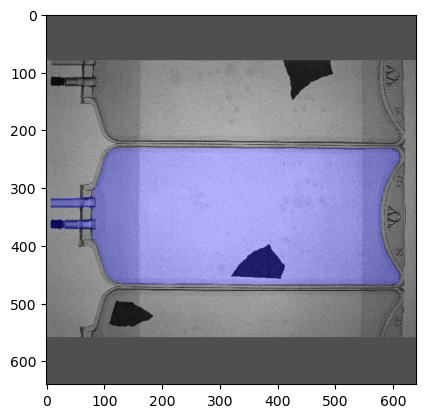

In [278]:
plt.imshow((lbox_img.astype(np.float64)*0.7 + msk_3*0.3).clip(0, 255).astype(np.uint8))

In [279]:
lbox_img.shape

(640, 640, 3)

In [280]:
msk_3.shape

(640, 640, 3)

In [281]:
ctrs = cv2.findContours(msk.squeeze().numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE, offset=(-1, -1))

In [282]:
len(ctrs)

2

In [284]:
draw = cv2.drawContours(lbox_img, ctrs[0], -1, (0,255,0), 3)

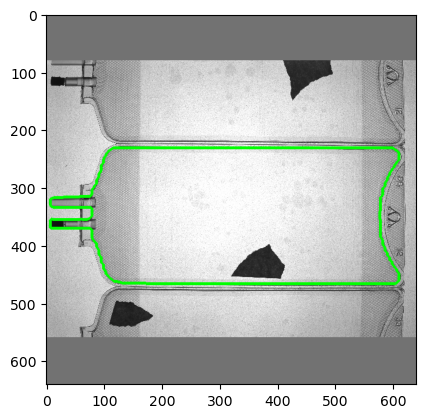

In [285]:
plt.imshow(draw)

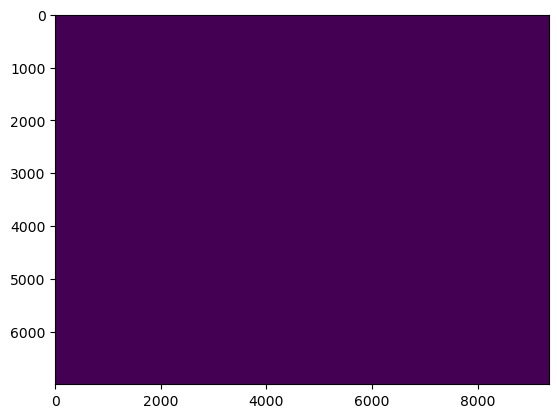

In [222]:
plt.imshow(msk.squeeze().numpy()*255)

In [319]:
segments = reversed(masks2segments(msk))

In [320]:
segments = [scale_segments((640, 640), x, img.shape, normalize=False) for x in segments]

In [337]:
draw = cv2.drawContours(img, (segments[0][:,np.newaxis,:].astype(np.int32)), -1, (0,255,0), 50)

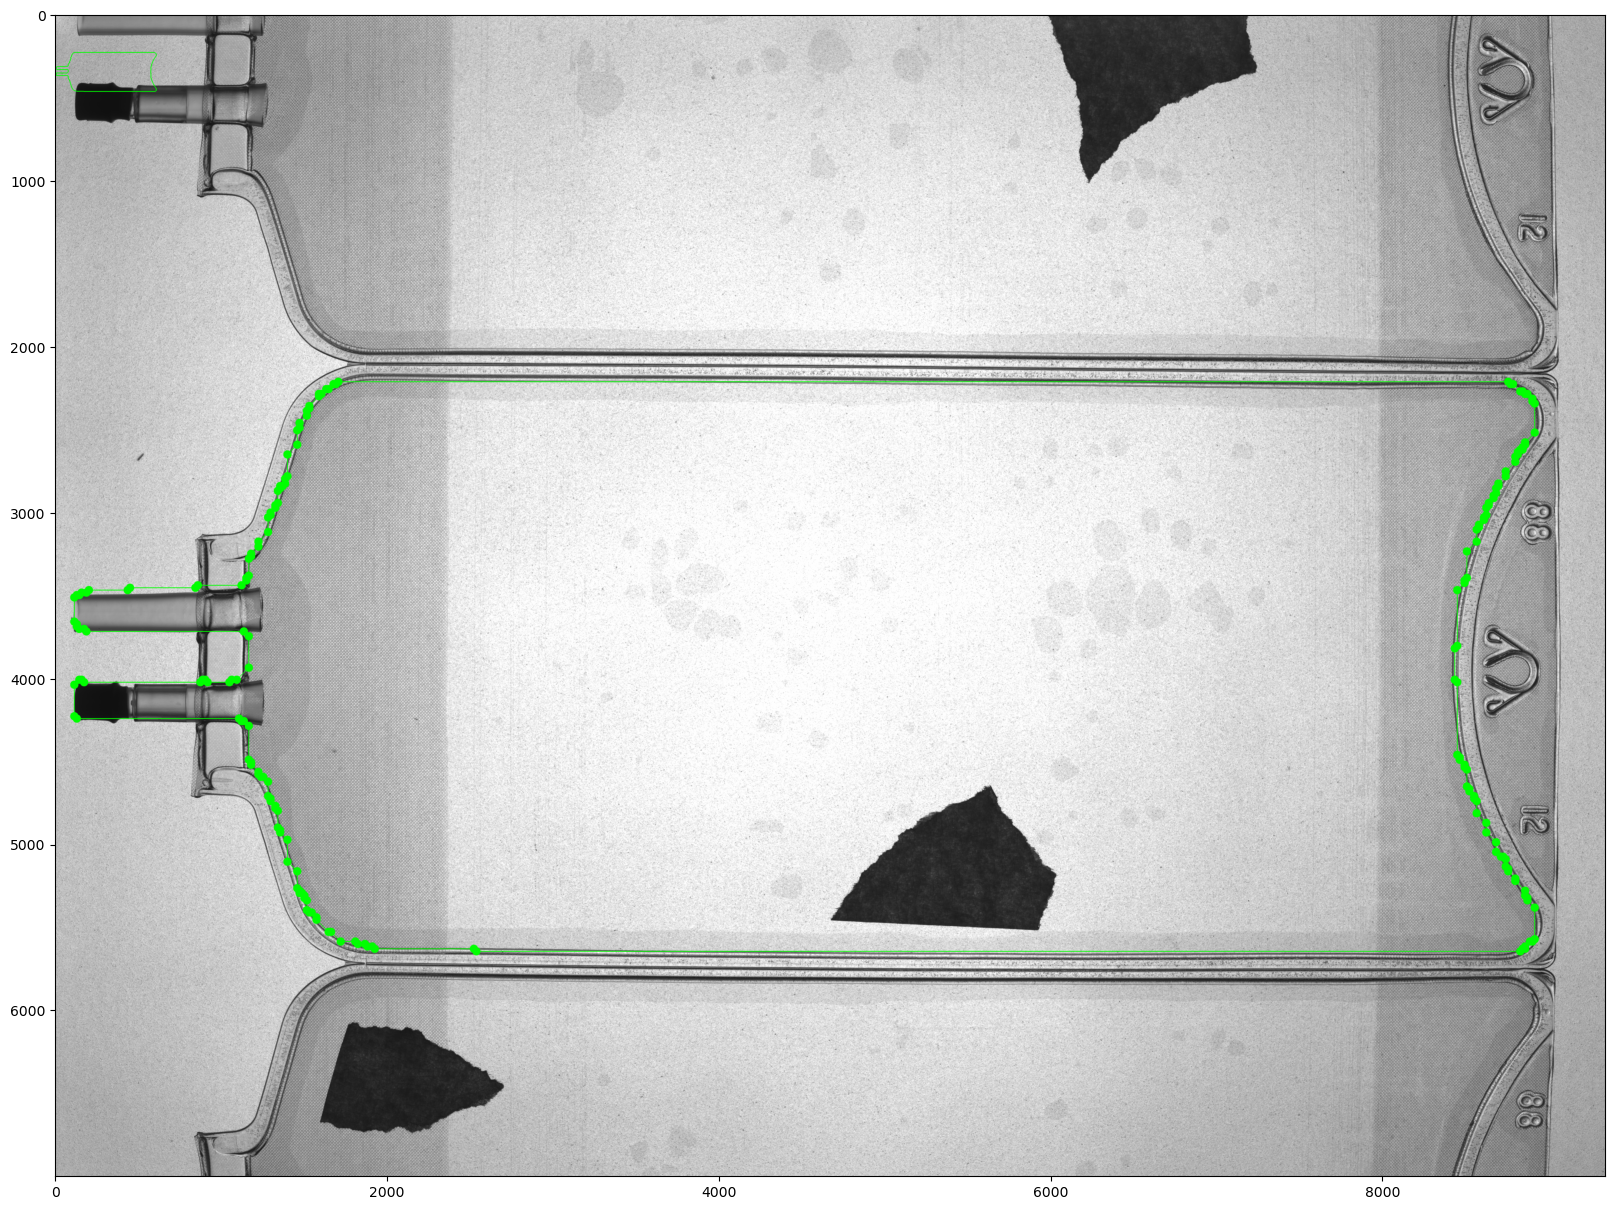

In [338]:
plt.figure(figsize=(20, 18))
plt.imshow(draw)